## Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains

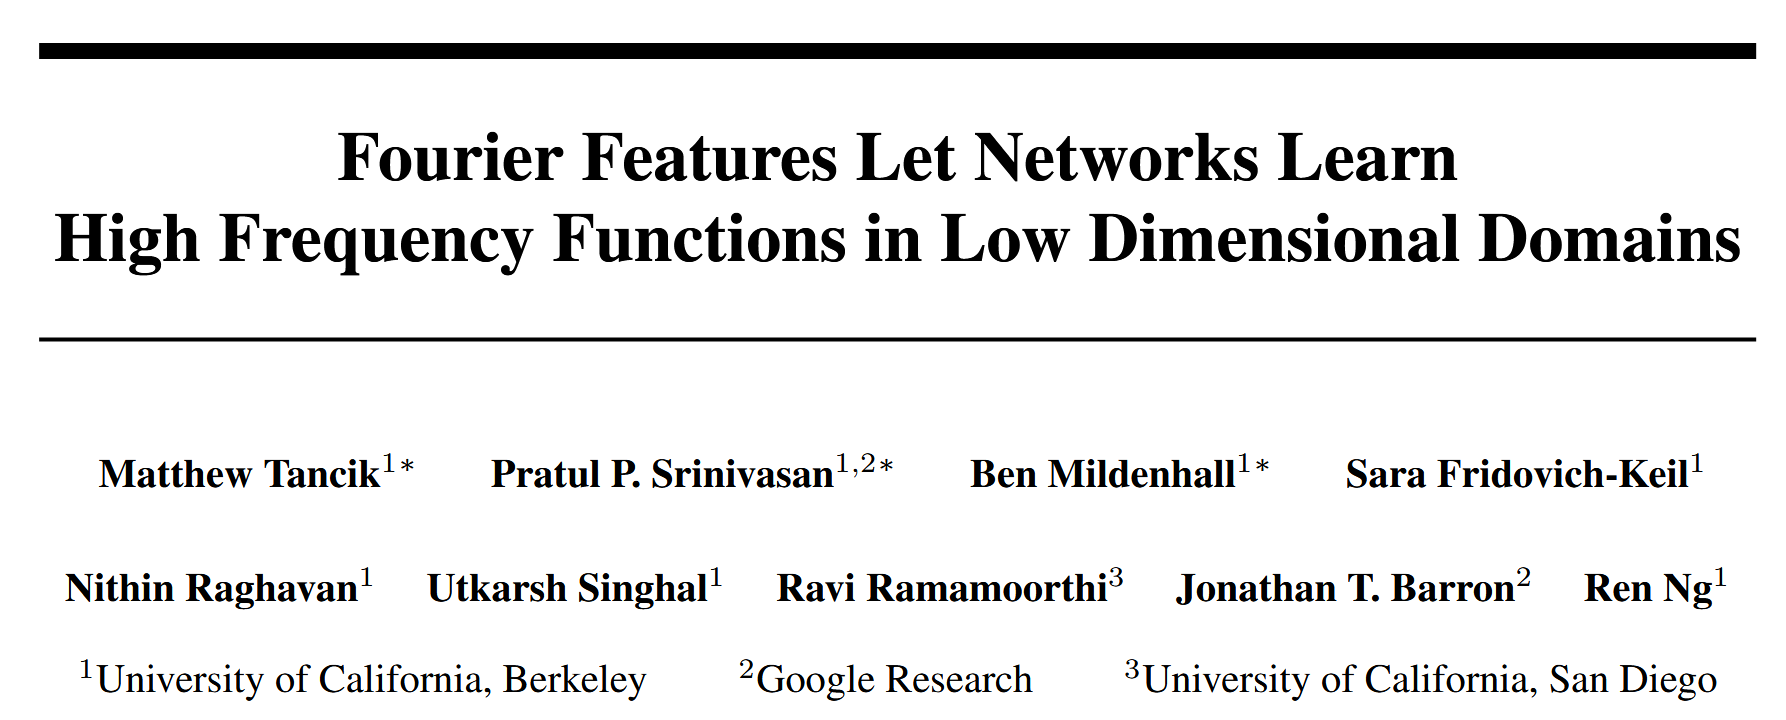

## 1. Highlights
Based on Neural Tangent Kernel(NTK) theory and Random Fourier Features (RFF), this paper maps input coordinates into a high-dimensional Fourier space to help neural networks capture high-frequency details, rather than just learning smooth, low-frequency patterns. The method is implemented in JAX for efficient kernel-level analysis and training.


## 2. Background

In recent years, **coordinate-based multilayer perceptrons (MLPs)** have emerged as a powerful representation for continuous signals in computer vision and graphics. These MLPs take spatial coordinates (e.g., 2D $(x, y)$ or 3D $(x, y, z)$) as inputs and output corresponding signal values, such as color, density, or occupancy. This method offers compactness and is well-suited for gradient-based learning, leading to impressive applications like NeRF (Mildenhall et al., 2020) and Occupancy Networks (Mescheder et al., 2019).
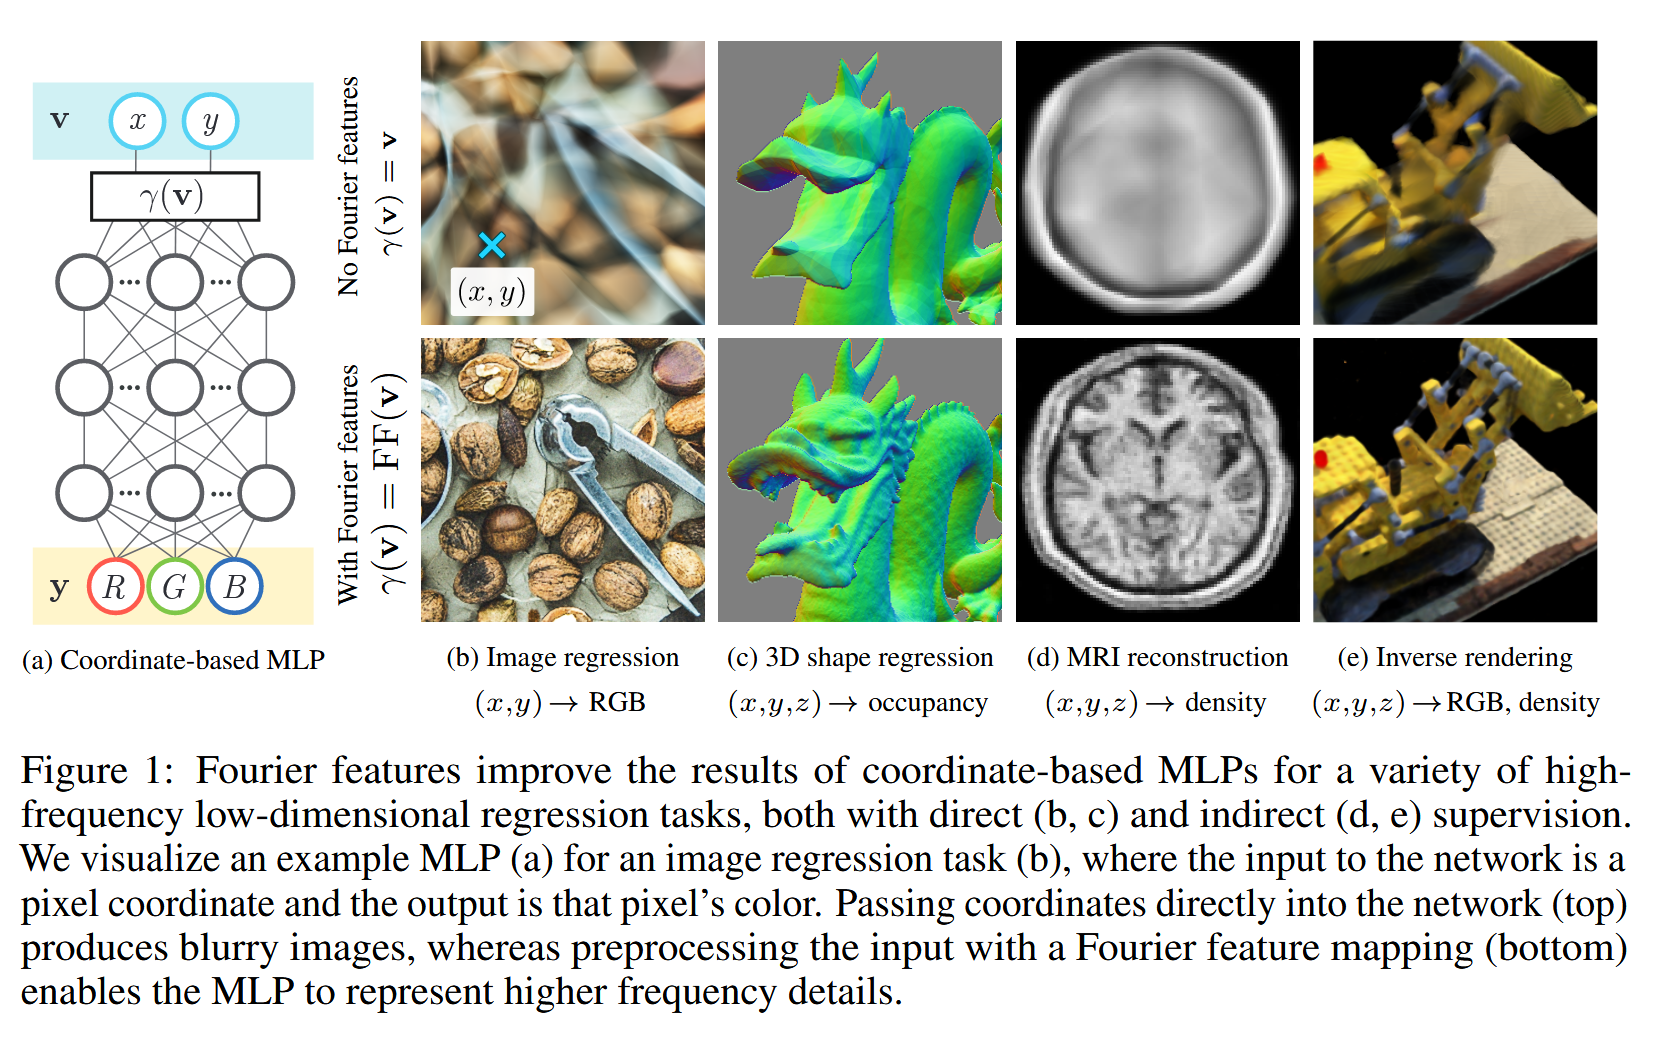
However, a key limitation of standard MLPs is their **spectral bias**: they favor learning low-frequency functions and struggle to capture high-frequency details, a challenge described in several studies such as Rahaman et al. (2019) and Basri et al. (2020).

To address this, the authors introduce **Fourier feature mappings**, inspired by **random Fourier features** from kernel theory (Rahimi & Recht, 2007). By transforming the input coordinates via sinusoidal functions before passing them to the MLP, they effectively modify the network's **Neural Tangent Kernel (NTK)** to become stationary and tunable, allowing the network to learn high-frequency components more efficiently.

About NKT: https://www.inference.vc/neural-tangent-kernels-some-intuition-for-kernel-gradient-descent/
When the width of a neural network tends to infinity, its training dynamics converge to those of a **kernel regression** model—specifically, one defined by the NTK. In this limit, the network behaves like a fixed linear model, and its entire training process can be understood analytically.
Imagine you slightly change the network’s output at one input—how does that affect the output at another input? NTK quantifies this interaction. Mathematically, it’s the inner product of the gradients of the network’s output with respect to its parameters, taken at two different inputs.

## 3. The Core Idea 

This paper builds on the theory of the Neural Tangent Kernel (NTK) by projecting input coordinates into a high-dimensional space, making the network more sensitive to high-frequency details. The projected features must still preserve the original structure of the input, which is where **kernel approximation** comes into play.

The projection is defined as:

$$
\gamma(\mathbf{v}) = \left[
a_1 \cos(2\pi \mathbf{b}_1^T \mathbf{v}),\ a_1 \sin(2\pi \mathbf{b}_1^T \mathbf{v}),\ \dots,\ a_m \cos(2\pi \mathbf{b}_m^T \mathbf{v}),\ a_m \sin(2\pi \mathbf{b}_m^T \mathbf{v})
\right]^T
$$

Here, $\mathbf{v} \in \mathbb{R}^d$ is the input coordinate, and each $\mathbf{b}_i \in \mathbb{R}^d$ is a randomly sampled frequency vector from a Gaussian distribution. The function $\gamma(\mathbf{v})$ maps $\mathbf{v}$ into a $2m$-dimensional space using sinusoidal components.

As for kernel approximation, a classic example of a kernel is the **Gaussian kernel**, which can be thought of as a smooth, blurry function: the closer two inputs are, the more similar they are treated. This "blurring" effect encodes locality, allowing the model to emphasize nearby relationships while gradually ignoring distant ones. To efficiently approximate such kernels, the paper adopts Random Fourier Features (RFF). RFF is a method for mapping inputs into a feature space where the inner product approximates a shift-invariant kernel function, like the Gaussian. By sampling random frequencies from a specific distribution and applying sine and cosine functions, RFF enables the network to capture both low and high-frequency patterns without requiring expensive kernel matrix computations.

<a href="https://colab.research.google.com/github/tancik/fourier-feature-networks/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo

In [ ]:
!pip install imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 28.2 kB/s eta 0:00:0000:0500:35


In [ ]:
import jax.numpy as np
from jax import jit, grad, random
from jax.example_libraries import stax, optimizers

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio

rand_key = random.PRNGKey(0)

## Set up data

/tmp/ipykernel_1634958/4027901983.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


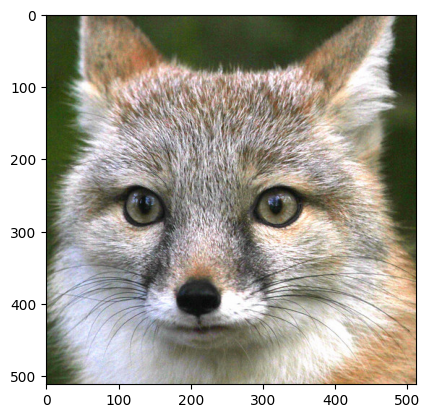

In [ ]:
# Download image, take a square crop from the center
image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
img = imageio.imread(image_url)[..., :3] / 255.
c = [img.shape[0]//2, img.shape[1]//2]
r = 256
img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

plt.imshow(img)
plt.show()

# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
test_data = [x_test, img]
train_data = [x_test[::2, ::2], img[::2, ::2]]

# Model and training code

Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

`input_mapping` corresponds to the equation:

$$
\gamma(\mathbf{v}) = \left[
a_1 \cos(2\pi \mathbf{b}_1^T \mathbf{v}),\ a_1 \sin(2\pi \mathbf{b}_1^T \mathbf{v}),\ \dots,\ a_m \cos(2\pi \mathbf{b}_m^T \mathbf{v}),\ a_m \sin(2\pi \mathbf{b}_m^T \mathbf{v})
\right]^T
$$

Here, the input coordinate $x$ (denoted as $\mathbf{v}$ in the paper) is projected onto a set of randomly sampled frequency vectors $B = [\mathbf{b}_1, \dots, \mathbf{b}_m]$ using $x @ B^T$. The result is multiplied by $2\pi$ to match the standard Fourier basis. Applying $\sin$ and $\cos$ to each projection captures both phase and amplitude information. Concatenating these values yields a $2m$-dimensional feature vector that encodes rich frequency content, allowing the network to model high-frequency variations more effectively.


In [ ]:
# Fourier feature mapping
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [ ]:
# JAX network definition
def make_network(num_layers, num_channels):
    layers = []
    for i in range(num_layers-1):
        layers.append(stax.Dense(num_channels))
        layers.append(stax.Relu)
    layers.append(stax.Dense(3))
    layers.append(stax.Sigmoid)
    return stax.serial(*layers)


# Train model with given hyperparameters and data
def train_model(network_size, learning_rate, iters, B, train_data, test_data):

    init_fn, apply_fn = make_network(*network_size)

    model_pred = jit(lambda params, x: apply_fn(params, input_mapping(x, B)))
    model_loss = jit(lambda params, x, y: .5 * np.mean((model_pred(params, x) - y) ** 2))
    model_psnr = jit(lambda params, x, y: -10 * np.log10(2.*model_loss(params, x, y)))
    model_grad_loss = jit(lambda params, x, y: grad(model_loss)(params, x, y))

    opt_init, opt_update, get_params = optimizers.adam(learning_rate)
    opt_update = jit(opt_update)

    _, params = init_fn(rand_key, (-1, input_mapping(train_data[0], B).shape[-1]))
    opt_state = opt_init(params)

    train_psnrs = []
    test_psnrs = []
    pred_imgs = []
    xs = []
    for i in tqdm(range(iters), desc='train iter', leave=False):
        opt_state = opt_update(i, model_grad_loss(get_params(opt_state), *train_data), opt_state)

        if i % 25 == 0:
            train_psnrs.append(model_psnr(get_params(opt_state), *train_data))
            test_psnrs.append(model_psnr(get_params(opt_state), *test_data))
            pred_imgs.append(model_pred(get_params(opt_state), test_data[0]))
            xs.append(i)

    return {
        'state': get_params(opt_state),
        'train_psnrs': train_psnrs,
        'test_psnrs': test_psnrs,
        'pred_imgs': np.stack(pred_imgs),
        'xs': xs,
    }

## Train networks with different input mappings

We compare the following mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

<!-- - Positional encoding: $\gamma(\mathbf{v})=\left[ \ldots, \cos(2 \pi \sigma^{j/m} \mathbf{v}),\sin(2 \pi \sigma^{j/m} \mathbf{v}), \ldots \right]^\mathrm{T}$ for $j = 0, \ldots, m-1$.  -->

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$

Why are the frequencies in $B$ sampled randomly from a Gaussian distribution?

According to the theory of Random Fourier Features, any shift-invariant kernel (like the Gaussian kernel) can be approximated by sampling frequency vectors $\mathbf{b}_i$ from the Fourier transform of that kernel. For the Gaussian kernel, this distribution is itself Gaussian. Random sampling ensures broad frequency coverage without manually choosing which frequencies to use. As long as enough samples are drawn, the resulting sine and cosine features will approximate the kernel function well—no training required.



In [5]:
network_size = (4, 256)
learning_rate = 1e-4
iters = 2000

mapping_size = 256

B_dict = {}
# Standard network - no mapping
B_dict['none'] = None
# Basic mapping
B_dict['basic'] = np.eye(2)
# Three different scales of Gaussian Fourier feature mappings
B_gauss = random.normal(rand_key, (mapping_size, 2))
for scale in [1., 10., 100.]:
  B_dict[f'gauss_{scale}'] = B_gauss * scale

# This should take about 2-3 minutes
outputs = {}
for k in tqdm(B_dict):
  outputs[k] = train_model(network_size, learning_rate, iters, B_dict[k], train_data, test_data)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

## Plot results

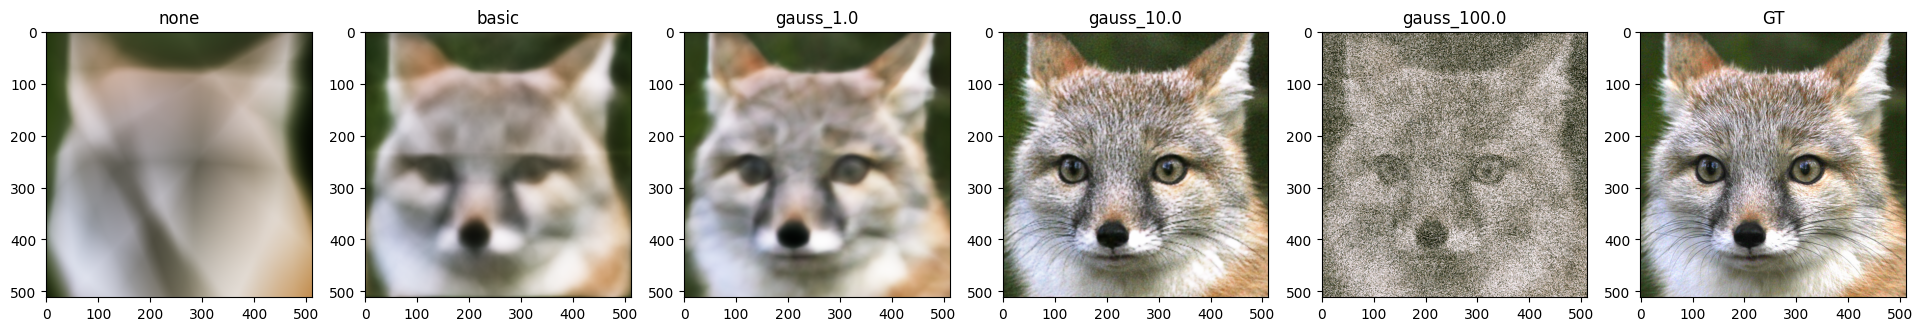

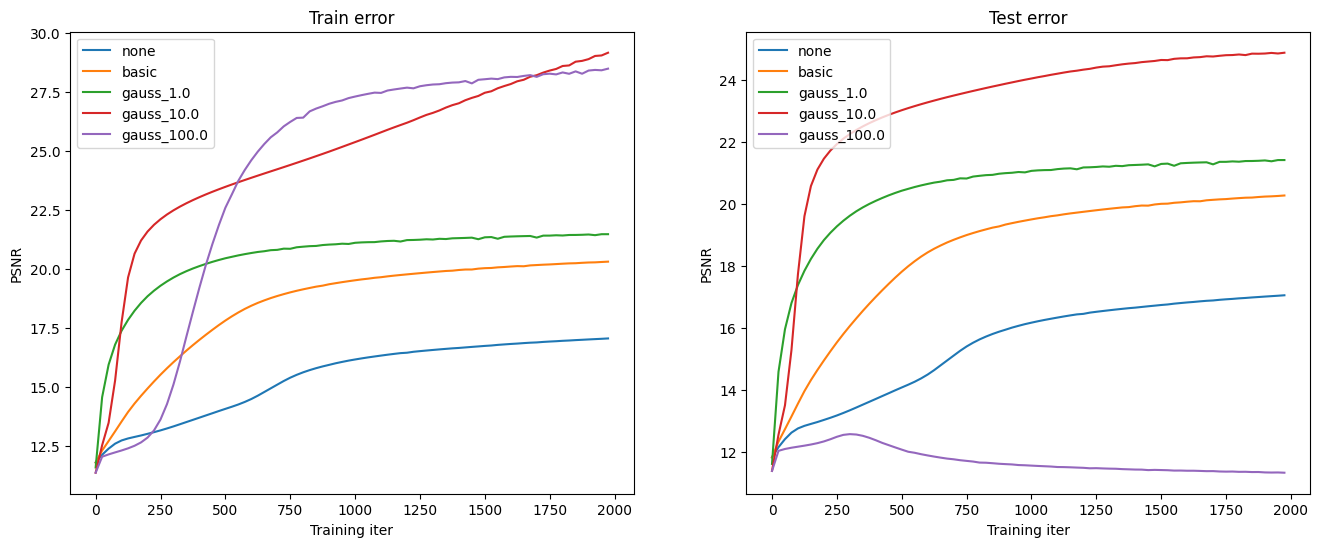

In [ ]:
# Show final network outputs

plt.figure(figsize=(24, 4))
N = len(outputs)
for i, k in enumerate(outputs):
    plt.subplot(1, N+1, i+1)
    plt.imshow(outputs[k]['pred_imgs'][-1])
    plt.title(k)
plt.subplot(1, N+1, N+1)
plt.imshow(img)
plt.title('GT')
plt.show()

# Plot train/test error curves

plt.figure(figsize=(16, 6))

plt.subplot(121)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['train_psnrs'], label=k)
plt.title('Train error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.subplot(122)
for i, k in enumerate(outputs):
    plt.plot(outputs[k]['xs'], outputs[k]['test_psnrs'], label=k)
plt.title('Test error')
plt.ylabel('PSNR')
plt.xlabel('Training iter')
plt.legend()

plt.show()

In [ ]:
# Save out video
all_preds = np.concatenate([outputs[n]['pred_imgs'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1000 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1000" cellspacing="0" cellpadding="0">
  <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))